# Using Bayesian Analysis to Analyze Terrorism

## Focus: Colombia

In this project I will use Bayesian statistics to take a look at University of Maryland's Global Terrorism Database. I have chose kidnapping in Colombia during the late 90's as my study subject. 

The project is divided into 4 parts:

1) I will perform Exploratory Data Analysis on our data

2) I will run a Bayesian analysis comparing two terrorist groups using kidnapping in late 90's Colombia.

3) To approximate real data for 1993 that was lost in the past, we will impute data based on trends.

4) I explain the methods used in a short write-up.

### Part 1: EDA

I begin by importing everything I will need, plus a few others things I might try during my process. I've commented some out post facto.
The functions defined here to assist the EDA are courtesy of current and previous GA students.

In [539]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import time
from datetime import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf, adfuller
# from sklearn.cross_validation import train_test_split, cross_val_score
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import LogisticRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def eda(dataframe):
    print "missing values \n", dataframe.isnull().sum()
    print "dataframe index \n", dataframe.index
    print "dataframe types \n", dataframe.dtypes
    print "dataframe shape \n", dataframe.shape
    print "dataframe describe \n", dataframe.describe()
    print "dataframe duplicates \n", dataframe.duplicated().sum() 
    for item in dataframe:
        print item
        print dataframe[item].nunique()
        
def eda_helper(df):
    dict_list = []
    for col in df.columns:
        data = df[col]
        dict_ = {}
        # The null count for a column. Columns with no nulls are generally more interesting
        dict_.update({"null_count" : data.isnull().sum()})
        # Counting the unique values in a column
        # This is useful for seeing how interesting the column might be as a feature
        dict_.update({"unique_count" : len(data.unique())})
        # Finding the types of data in the column
        # This is useful for finding out potential problems with a column having strings and ints
        dict_.update({"data_type" : set([type(d).__name__ for d in data])})
        #dict_.update({"score" : match[1]})
        dict_list.append(dict_)
    eda_df = pd.DataFrame(dict_list)
    eda_df.index = df.columns
    #eda_df = eda_df.sort_values(['null_count','unique_count'], ascending=[True, False])
    return eda_df

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [540]:
data = pd.read_csv('/Users/andresgonzalez/Desktop/GA/curriculum/project_5/gtd.csv')

In [541]:
print data.head()

        eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region   ...    addnotes scite1 scite2  scite3  \
0  Dominican Republic       2   ...         NaN    NaN    NaN     NaN   
1              Mexico       1   ...         NaN    NaN    NaN     NaN   
2         Philippines       5   ...         NaN    NaN    NaN     NaN   
3              Greece       8   ...         NaN    NaN    NaN     NaN   
4               Japan       4   ...         NaN    NaN    NaN     NaN   

   dbsource  INT_LOG  INT_IDEO INT_MISC INT_ANY  related  
0      PGIS    

In [542]:
for i in enumerate(data.columns):  # After studying the GTD codebook I came to the data with some knowledge of what I would need.
    print i                        # This will allow me to drop columns by chunks

(0, 'eventid')
(1, 'iyear')
(2, 'imonth')
(3, 'iday')
(4, 'approxdate')
(5, 'extended')
(6, 'resolution')
(7, 'country')
(8, 'country_txt')
(9, 'region')
(10, 'region_txt')
(11, 'provstate')
(12, 'city')
(13, 'latitude')
(14, 'longitude')
(15, 'specificity')
(16, 'vicinity')
(17, 'location')
(18, 'summary')
(19, 'crit1')
(20, 'crit2')
(21, 'crit3')
(22, 'doubtterr')
(23, 'alternative')
(24, 'alternative_txt')
(25, 'multiple')
(26, 'success')
(27, 'suicide')
(28, 'attacktype1')
(29, 'attacktype1_txt')
(30, 'attacktype2')
(31, 'attacktype2_txt')
(32, 'attacktype3')
(33, 'attacktype3_txt')
(34, 'targtype1')
(35, 'targtype1_txt')
(36, 'targsubtype1')
(37, 'targsubtype1_txt')
(38, 'corp1')
(39, 'target1')
(40, 'natlty1')
(41, 'natlty1_txt')
(42, 'targtype2')
(43, 'targtype2_txt')
(44, 'targsubtype2')
(45, 'targsubtype2_txt')
(46, 'corp2')
(47, 'target2')
(48, 'natlty2')
(49, 'natlty2_txt')
(50, 'targtype3')
(51, 'targtype3_txt')
(52, 'targsubtype3')
(53, 'targsubtype3_txt')
(54, 'corp3')
(5

In [543]:
# Dropping columns I won't use for my analysis
data.drop(data.columns[range(83, 135)], axis=1, inplace=True)
data.drop(data.columns[range(59, 81)], axis=1, inplace=True)
data.drop(data.columns[range(36, 58)], axis=1, inplace=True)
data.drop(data.columns[range(30, 34)], axis=1, inplace=True)
data.drop(data.columns[range(15, 26)], axis=1, inplace=True)


In [544]:
print data.columns  # Finding the last remaining columns I want to drop
data.head()

Index([u'eventid', u'iyear', u'imonth', u'iday', u'approxdate', u'extended',
       u'resolution', u'country', u'country_txt', u'region', u'region_txt',
       u'provstate', u'city', u'latitude', u'longitude', u'success',
       u'suicide', u'attacktype1', u'attacktype1_txt', u'targtype1',
       u'targtype1_txt', u'gname', u'weaptype1', u'weaptype1_txt'],
      dtype='object')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,longitude,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,gname,weaptype1,weaptype1_txt
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,-69.951164,1,0,1,Assassination,14,Private Citizens & Property,MANO-D,13,Unknown
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,-99.133207,1,0,6,Hostage Taking (Kidnapping),7,Government (Diplomatic),23rd of September Communist League,13,Unknown
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,120.599741,1,0,1,Assassination,10,Journalists & Media,Unknown,13,Unknown
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,23.728157,1,0,3,Bombing/Explosion,7,Government (Diplomatic),Unknown,6,Explosives/Bombs/Dynamite
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,130.396361,1,0,7,Facility/Infrastructure Attack,7,Government (Diplomatic),Unknown,8,Incendiary


In [545]:
data.drop(['extended' , 'resolution', 'provstate', 'suicide'], axis=1, inplace=True)

In [546]:
eda(data)

missing values 
eventid                 0
iyear                   0
imonth                  0
iday                    0
approxdate         162886
country                 0
country_txt             0
region                  0
region_txt              0
city                  446
latitude             4606
longitude            4606
success                 0
attacktype1             0
attacktype1_txt         0
targtype1               0
targtype1_txt           0
gname                   0
weaptype1               0
weaptype1_txt           0
dtype: int64
dataframe index 
RangeIndex(start=0, stop=170350, step=1)
dataframe types 
eventid              int64
iyear                int64
imonth               int64
iday                 int64
approxdate          object
country              int64
country_txt         object
region               int64
region_txt          object
city                object
latitude           float64
longitude          float64
success              int64
attacktype1          int6

In [547]:
data.drop(['approxdate'], axis=1, inplace=True)
eda_helper(data)

,data_type,null_count,unique_count
eventid,{int64},0,170350
iyear,{int64},0,46
imonth,{int64},0,13
iday,{int64},0,32
country,{int64},0,205
country_txt,{str},0,205
region,{int64},0,12
region_txt,{str},0,12
city,"{float, str}",446,33958
latitude,{float64},4606,61029


In [548]:
# I'm curious what the non-string city values are. Not very interesting. 
for i in data.city:
    if type(i).__name__ == "float":
        print i
    else:
        pass
    

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [549]:
# Created dframes with the day/month/year zero. Wanted to see how many I was dealing with in relation to the size of the pop.
day0= data[data['iday']==0]
month0= data[data['imonth']==0]
year0= data[data['iyear']==0]

print day0.shape, month0.shape, year0.shape

(891, 19) (20, 19) (0, 19)


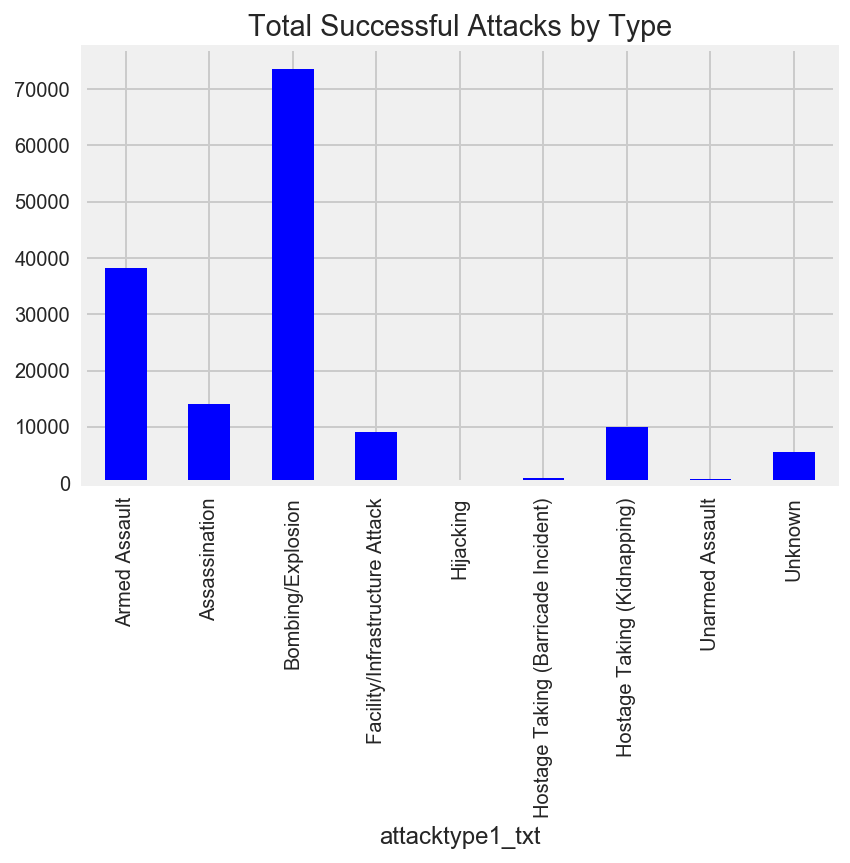

In [594]:
# Looking at distribution of attacks by type
data.groupby('attacktype1_txt').success.sum().plot(kind='bar', color='b', label='# of Successful Attacks')
plt.title("Total Successful Attacks by Type")
# plt.xlabel('# of attacks')
plt.show()

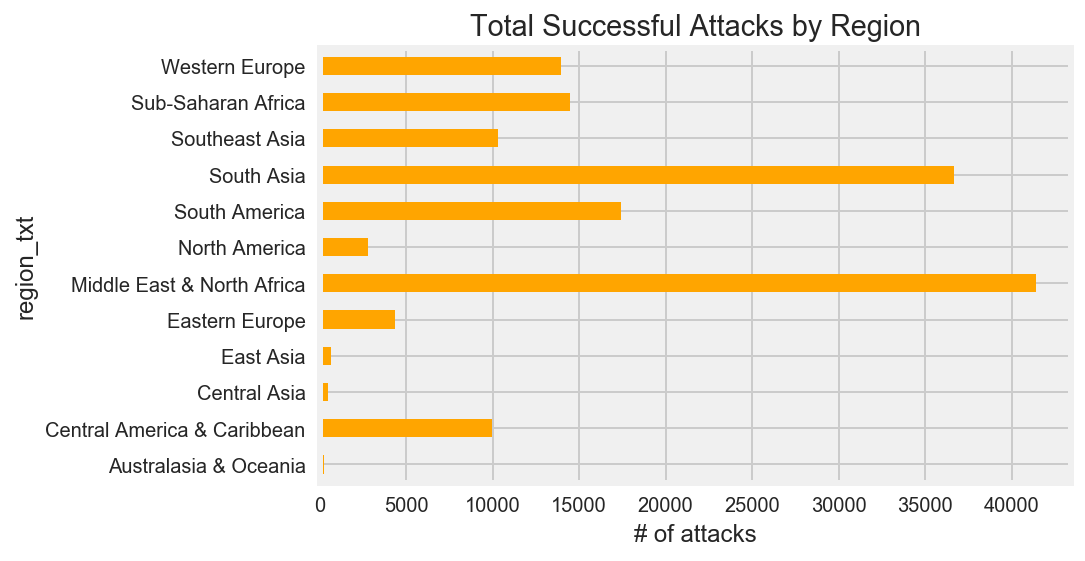

In [551]:
# Looking at attacks by region. Horizontal because the qualitative variables read better.
data.groupby('region_txt').success.sum().plot(kind='barh', color='orange', label='# of Successful Attacks')
plt.title("Total Successful Attacks by Region")
plt.xlabel('# of attacks')
plt.show()

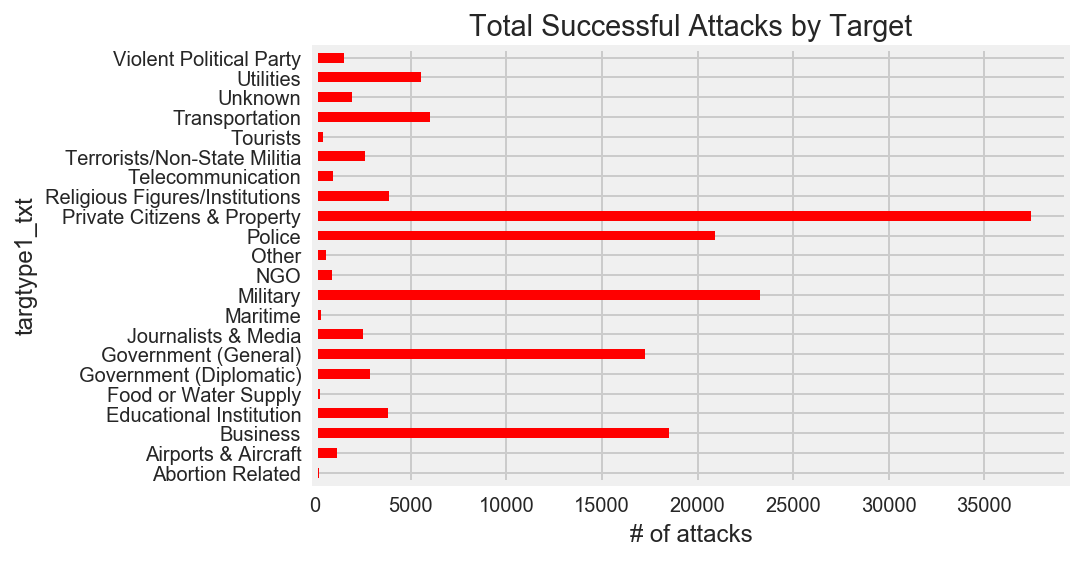

In [552]:
# Checking the target distro to see if there was something that jumped at me as not ordinary. Nothing really did. Maybe slightly surprised at thte low count for "Violent Political Party"
data.groupby('targtype1_txt').success.sum().plot(kind='barh', color='r', label='# of Successful Attacks')
plt.title("Total Successful Attacks by Target")
plt.xlabel('# of attacks')
plt.show()

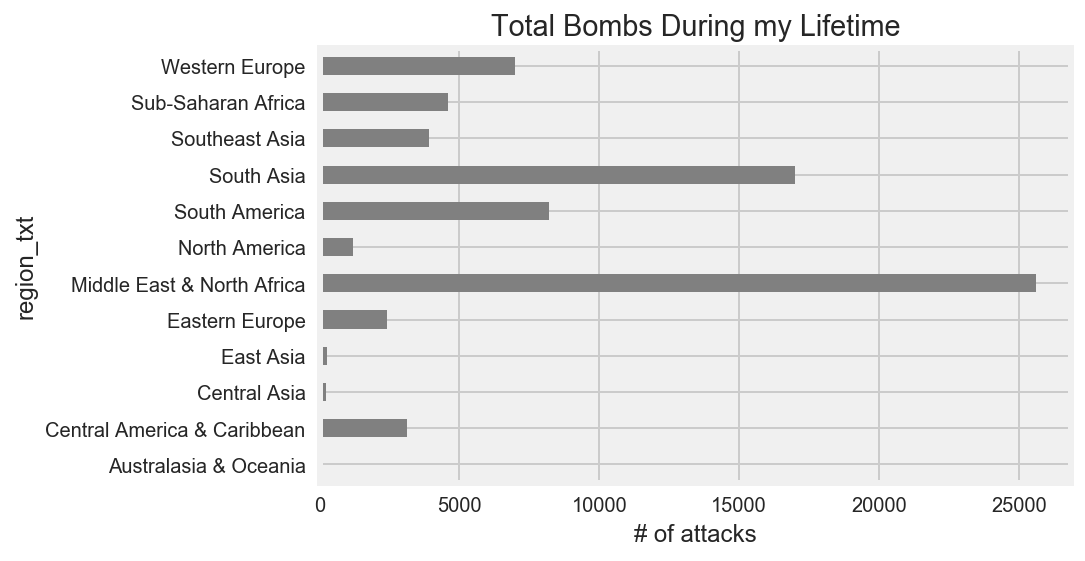

In [591]:
# I knew eventually we would look at bombings, so I wanted to get started with some context. I limited this graph to my lifetime to see if I could confirm my suspicions about high activity in South America

mylifetime = data[data.iyear>1983]
mylifetime = mylifetime[mylifetime.attacktype1 == 3]
mylifetime.groupby('region_txt').success.sum().plot(kind='barh', color='grey', label='# of Successful Attacks')
plt.title("Total Bombs During my Lifetime")
plt.xlabel('# of attacks')
plt.show()

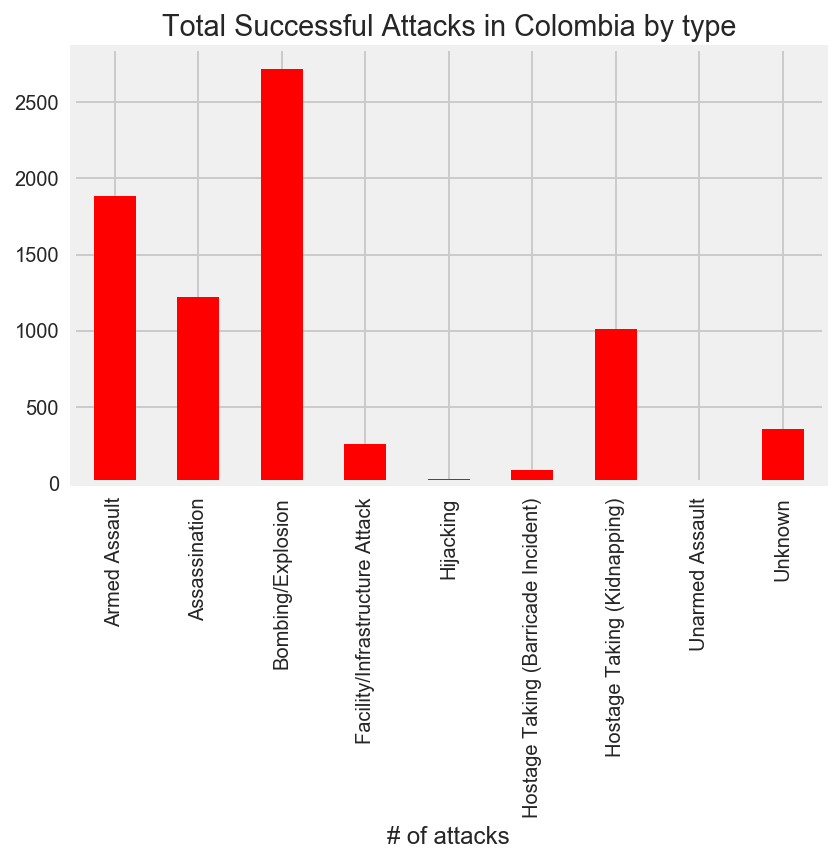

In [593]:
#Now fosucing on Colombia. This also served to set up my bayesian analysis comparing rebel groups and their use of kidnapping.

mylifetime = data[data.iyear>1983]  # Yes, I'm old...

mylifetime = mylifetime[mylifetime.country == 45]

mylifetime.groupby('attacktype1_txt').success.sum().plot(kind='bar', color='r', label='# of Successful Attacks')
plt.title("Total Successful Attacks in Colombia by type")
plt.xlabel('# of attacks')
plt.show()

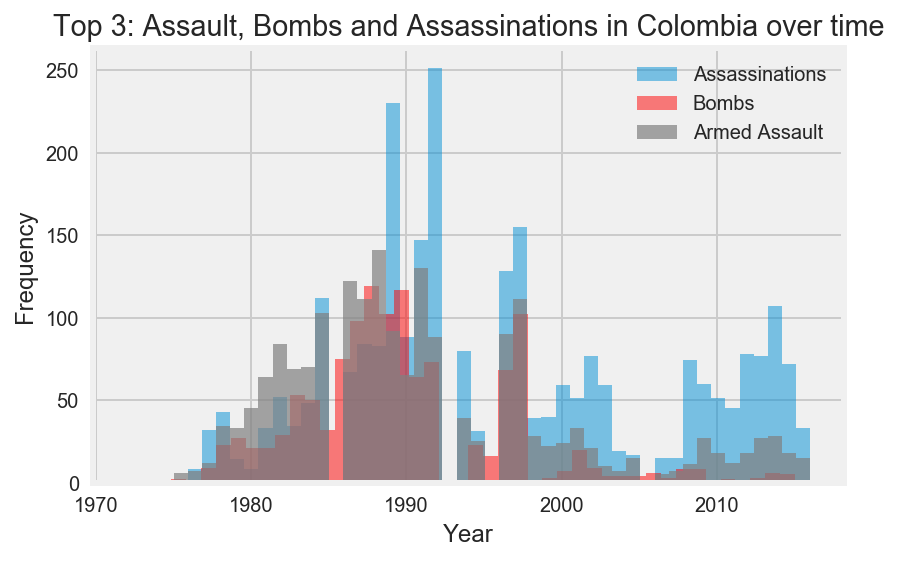

In [559]:
# Here I repolotted the top three attack types within the context of Colombia. Mildly interesting, but it's a little visually busy.
plt.hist(data[(data.attacktype1 ==3) & (data.country == 45)& (data.success==1)]['iyear'],bins = 45, alpha=.5, label='Assassinations')
plt.hist(data[(data.attacktype1 ==1) & (data.country == 45)& (data.success==1)]['iyear'],color ='r',bins = 45, alpha=0.5, label='Bombs')
plt.hist(data[(data.attacktype1 ==2) & (data.country == 45)& (data.success==1)]['iyear'],color ='grey',bins = 45, alpha=0.7, label='Armed Assault')
plt.title("Top 3: Assault, Bombs and Assassinations in Colombia over time")
plt.ylabel('Frequency')
plt.xlabel('Year')
plt.legend()
plt.show()

In [560]:
# Datetime won't work unless I convert the value to integers
data.iyear = data.iyear.astype(str)
data.imonth = data.imonth.astype(str)
data.iday = data.iday.astype(str)
data.head

<bound method DataFrame.head of              eventid iyear imonth iday  country  \
0       197000000001  1970      7    2       58   
1       197000000002  1970      0    0      130   
2       197001000001  1970      1    0      160   
3       197001000002  1970      1    0       78   
4       197001000003  1970      1    0      101   
5       197001010002  1970      1    1      217   
6       197001020001  1970      1    2      218   
7       197001020002  1970      1    2      217   
8       197001020003  1970      1    2      217   
9       197001030001  1970      1    3      217   
10      197001050001  1970      1    1      217   
11      197001060001  1970      1    6      217   
12      197001080001  1970      1    8       98   
13      197001090001  1970      1    9      217   
14      197001090002  1970      1    9      217   
15      197001100001  1970      1   10      499   
16      197001110001  1970      1   11       65   
17      197001120001  1970      1   12      217   

In [561]:
# Here are perhaps the most important decisions I made in regards to my data: I decided to treat day = 0 and month = 0 as follows:
# Day 0 was given value 1. Month 0 entries were randomly distributed throughout the year. The rationale was to try and distribute the error, but when I realized I would be working almost exclusively with year aggregates, this ended up having little influence.
data['iday'] = data['iday'].replace("0", "1")
data['imonth'] = data['imonth'].replace("0", str(np.random.randint(1,13)))

In [562]:
# Create a column using a DateTime friendly format of the dates
data.datetime = data[['iyear', 'imonth', 'iday']].apply(lambda x: '/'.join(x), axis=1)

data.head()

,eventid,iyear,imonth,iday,country,country_txt,region,region_txt,city,latitude,longitude,success,attacktype1,attacktype1_txt,targtype1,targtype1_txt,gname,weaptype1,weaptype1_txt
0,197000000001,1970,7,2,58,Dominican Republic,2,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,1,1,Assassination,14,Private Citizens & Property,MANO-D,13,Unknown
1,197000000002,1970,12,1,130,Mexico,1,North America,Mexico city,19.432608,-99.133207,1,6,Hostage Taking (Kidnapping),7,Government (Diplomatic),23rd of September Communist League,13,Unknown
2,197001000001,1970,1,1,160,Philippines,5,Southeast Asia,Unknown,15.478598,120.599741,1,1,Assassination,10,Journalists & Media,Unknown,13,Unknown
3,197001000002,1970,1,1,78,Greece,8,Western Europe,Athens,37.983773,23.728157,1,3,Bombing/Explosion,7,Government (Diplomatic),Unknown,6,Explosives/Bombs/Dynamite
4,197001000003,1970,1,1,101,Japan,4,East Asia,Fukouka,33.580412,130.396361,1,7,Facility/Infrastructure Attack,7,Government (Diplomatic),Unknown,8,Incendiary


In [563]:
# set data frame to use datetime and cull down the dataframe to only include successes
# I chose to work only with successes out of fear of misreaporting or undereporting by government and groups to further any contemporary agenda.
data['datetime'] = pd.to_datetime(data.datetime)
data = data[data['success']==1]

In [564]:
data.set_index('datetime', inplace=True)

In [565]:
dftimebomb = data.groupby('datetime').aggregate(len)['iyear']
dftimebomb.head()

datetime
1970-01-01    4
1970-01-02    2
1970-01-03    1
1970-01-06    1
1970-01-08    1
Name: iyear, dtype: int64

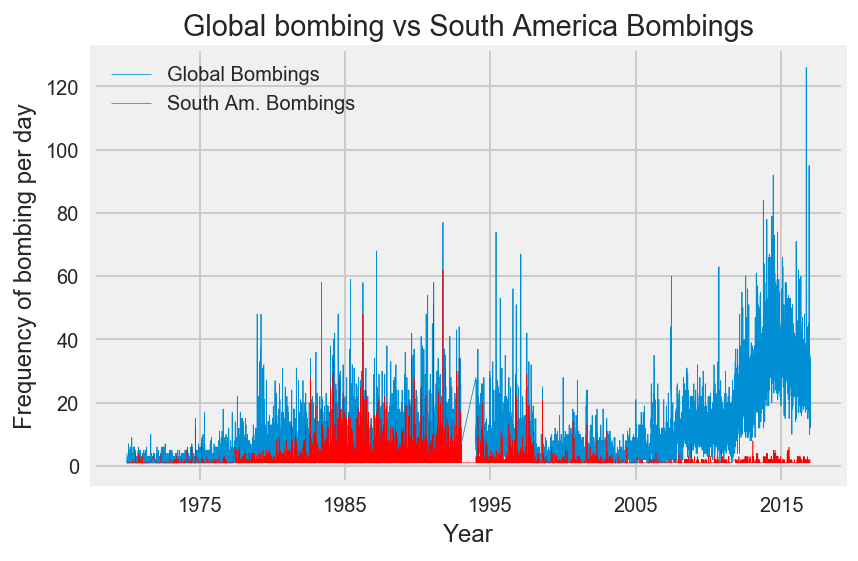

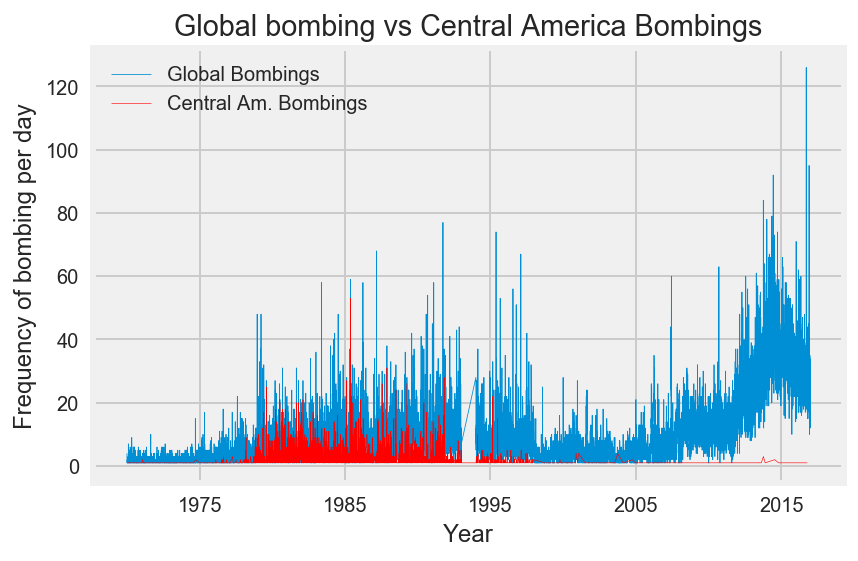

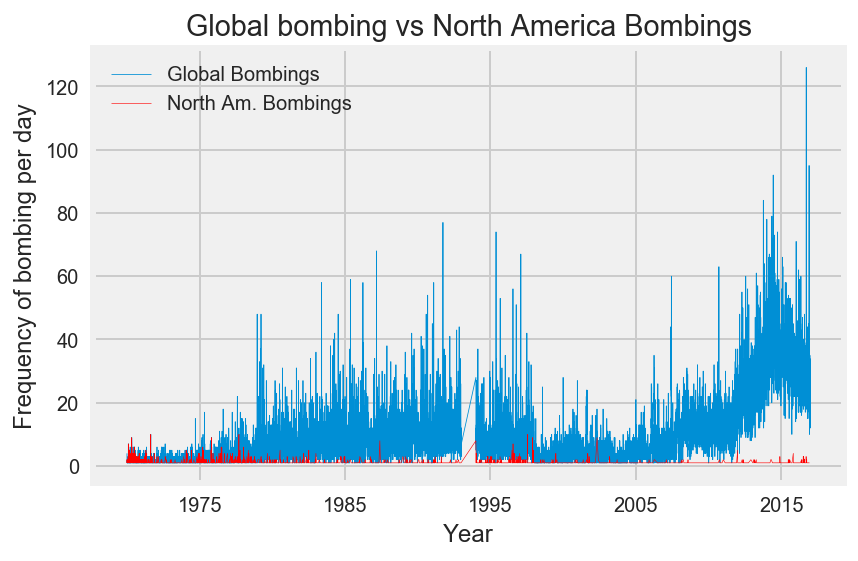

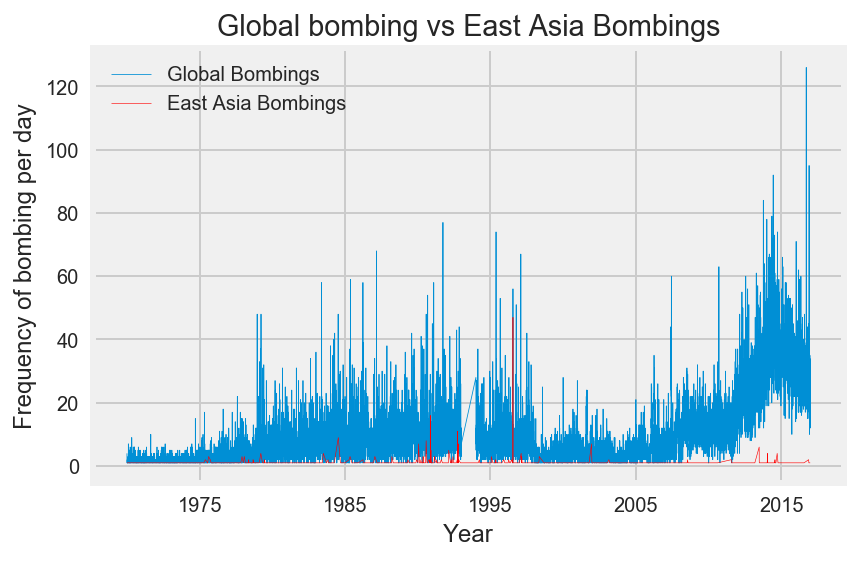

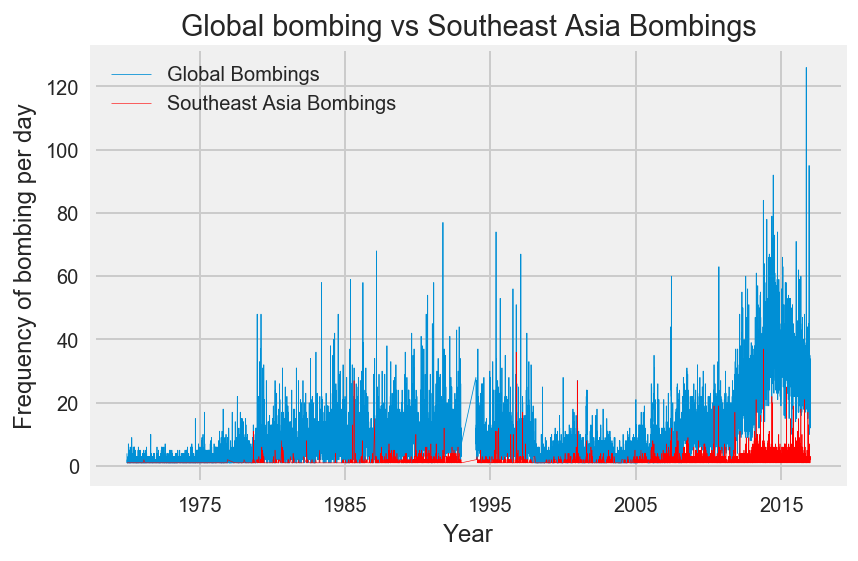

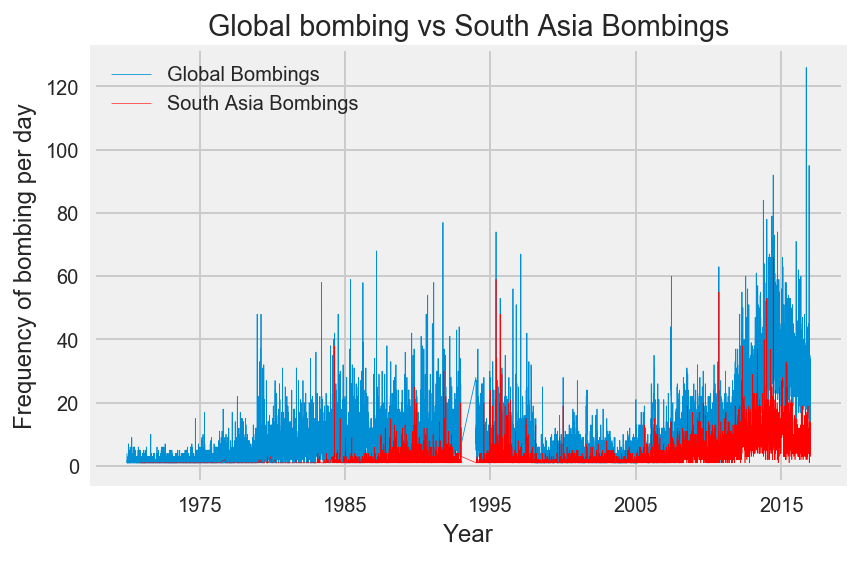

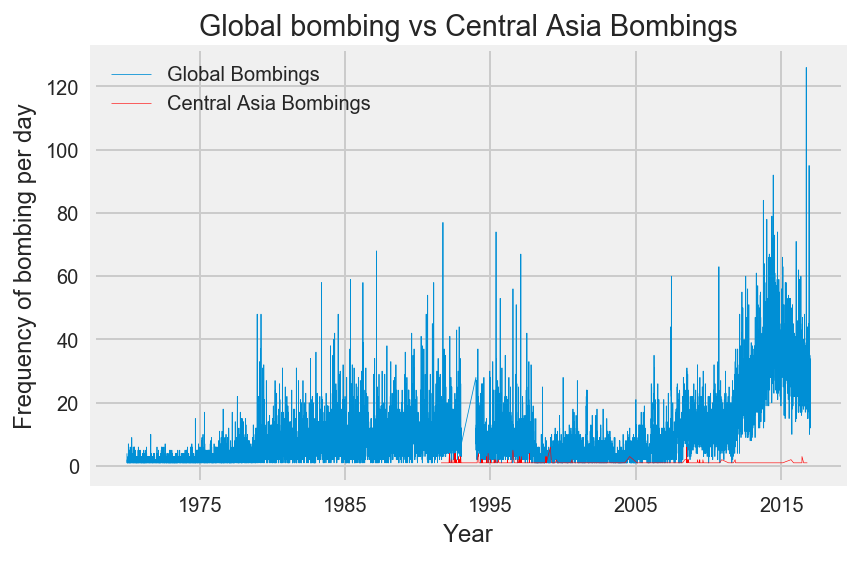

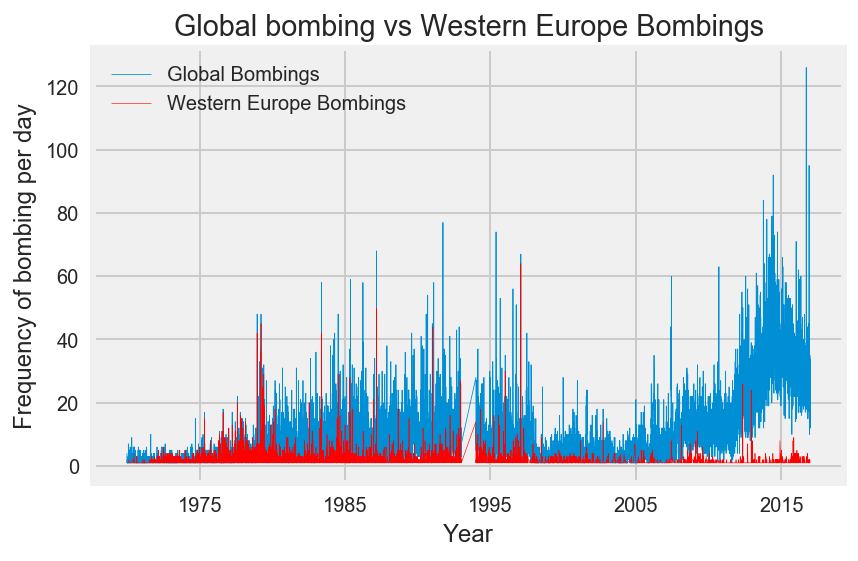

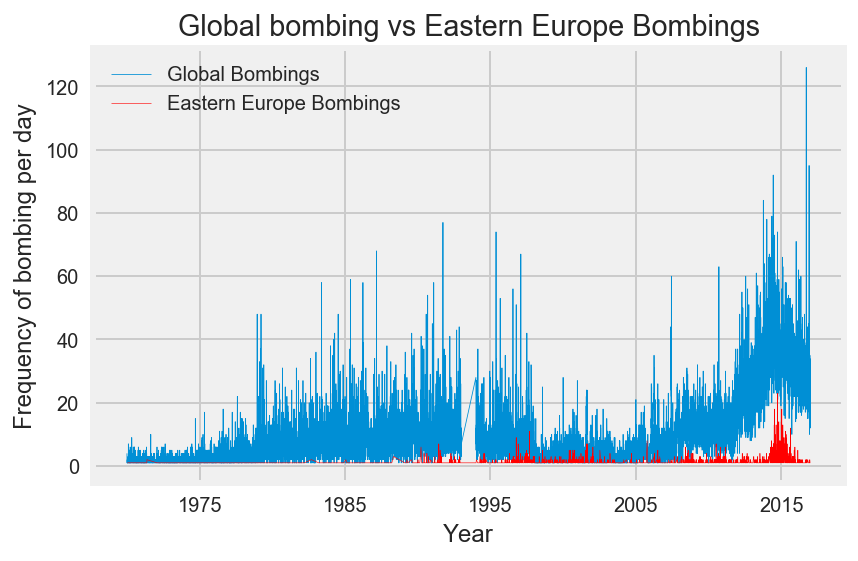

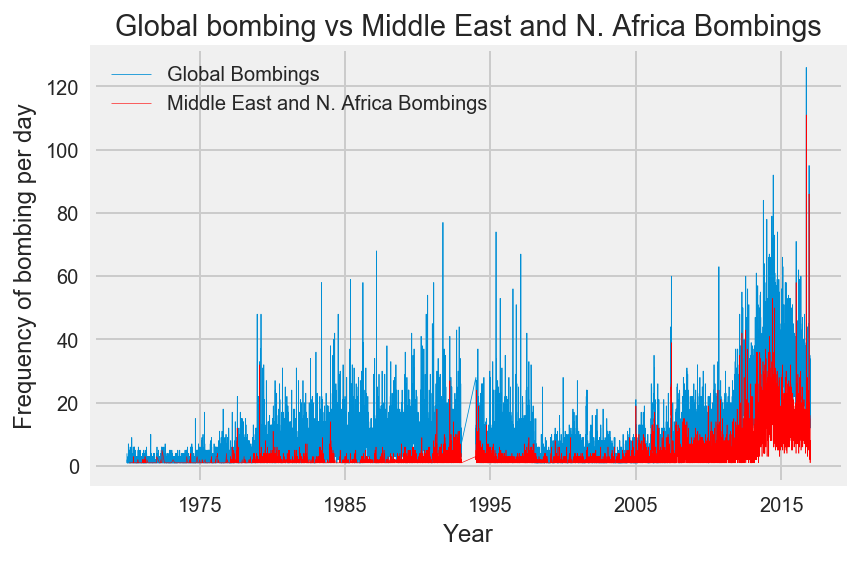

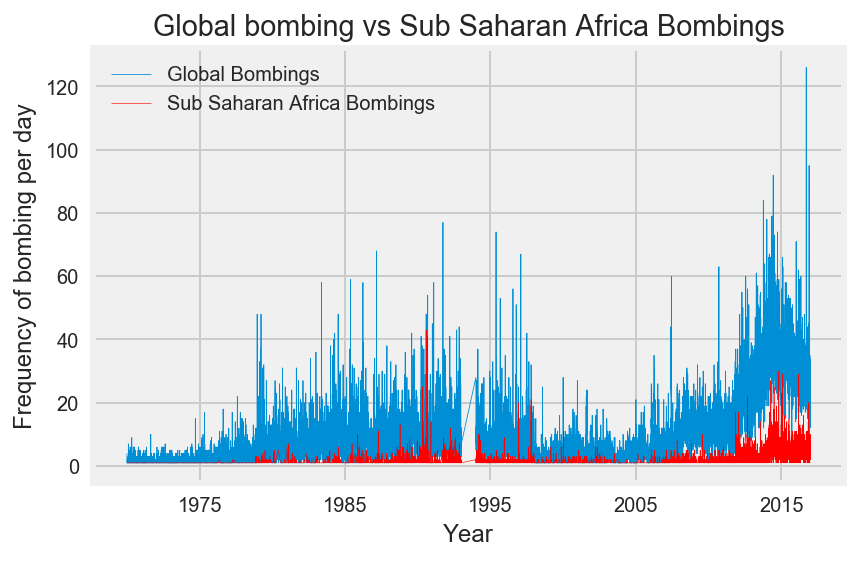

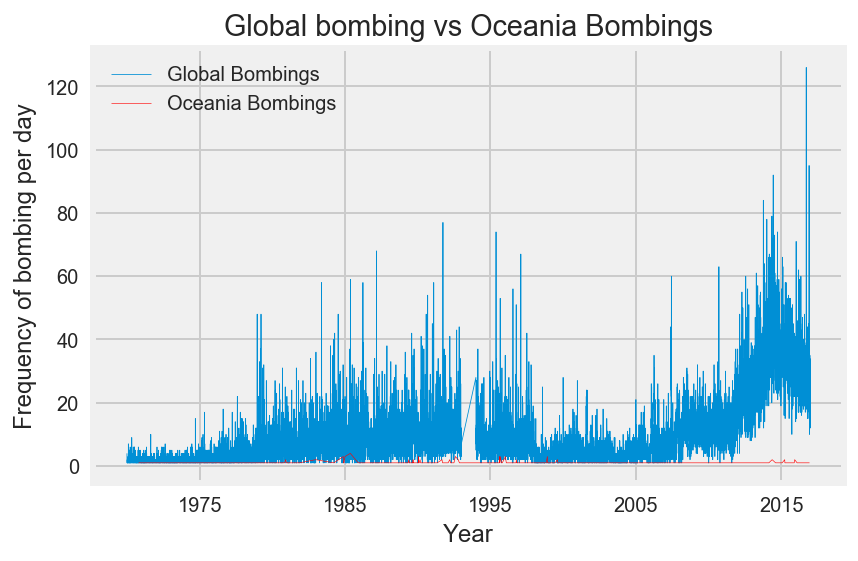

In [566]:
# I created a series of graphs by region to visually understand the relationship and effect of the variable bomb attacks by region, over time.
# From it I learned how the conflict with terrorism shifted from the western hemisphere to the Middle East and Asia.

dtbsa = data[data['region'] == 3]
dtbsa = dtbsa.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbsa.index, dtbsa.values, lw=.3, color='r', label="South Am. Bombings")
plt.title("Global bombing vs South America Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

dtbca = data[data['region'] == 2]
dtbca = dtbca.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbca.index, dtbca.values, lw=.3, color='r', label="Central Am. Bombings")
plt.title("Global bombing vs Central America Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

dtbna = data[data['region'] == 1]
dtbna = dtbna.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbna.index, dtbna.values, lw=.3, color='r', label="North Am. Bombings")
plt.title("Global bombing vs North America Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

dtbea = data[data['region'] == 4]
dtbea = dtbea.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbea.index, dtbea.values, lw=.3, color='r', label="East Asia Bombings")
plt.title("Global bombing vs East Asia Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

dtbsea = data[data['region'] == 5]
dtbsea = dtbsea.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbsea.index, dtbsea.values, lw=.3, color='r', label="Southeast Asia Bombings")
plt.title("Global bombing vs Southeast Asia Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

dtbsa = data[data['region'] == 6]
dtbsa = dtbsa.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbsa.index, dtbsa.values, lw=.3, color='r', label="South Asia Bombings")
plt.title("Global bombing vs South Asia Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

dtbcas = data[data['region'] == 7]
dtbcas = dtbcas.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbcas.index, dtbcas.values, lw=.3, color='r', label="Central Asia Bombings")
plt.title("Global bombing vs Central Asia Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

dtbwe = data[data['region'] == 8]
dtbwe = dtbwe.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbwe.index, dtbwe.values, lw=.3, color='r', label="Western Europe Bombings")
plt.title("Global bombing vs Western Europe Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

dtbee = data[data['region'] == 9]
dtbee = dtbee.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbee.index, dtbee.values, lw=.3, color='r', label="Eastern Europe Bombings")
plt.title("Global bombing vs Eastern Europe Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

dtbme = data[data['region'] == 10]
dtbme = dtbme.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbme.index, dtbme.values, lw=.3, color='r', label="Middle East and N. Africa Bombings")
plt.title("Global bombing vs Middle East and N. Africa Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

dtbssa = data[data['region'] == 11]
dtbssa = dtbssa.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbssa.index, dtbssa.values, lw=.3, color='r', label="Sub Saharan Africa Bombings")
plt.title("Global bombing vs Sub Saharan Africa Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

dtbau = data[data['region'] == 12]
dtbau = dtbau.groupby('datetime').aggregate(len)['iyear']

plt.plot(dftimebomb.index, dftimebomb.values, lw=.4, label="Global Bombings")
plt.plot(dtbau.index, dtbau.values, lw=.3, color='r', label="Oceania Bombings")
plt.title("Global bombing vs Oceania Bombings")
plt.xlabel('Year')
plt.ylabel("Frequency of bombing per day")
plt.legend()
plt.show()

## Part 2: Bayesian Inference

As detailed later in the write-up at the end of this notebook, my bayesian interpretation will revolve around the FARC and ELN; leftist marxists guerrilla groups in Colombia. More specifically, I want to see if there was a difference in the use of kidnappings as a terror tactic, while kidnapping were at the height of their use for the groups' financing.

In [567]:
# Setting up the dataframe I'll be working with. Kidnappings (attacktype 6) in Colombia (Country = 45). 

dfkid = data[(data.attacktype1 == 6) & (data.country == 45)]
dfkid[['iyear']] = dfkid[['iyear']].astype(int)

In [568]:
# My analysis setup is based on 1998 as the year when the struggle reached a climax and government forces turned the tide in the conflict.
# It's also around the time I left Colombia, and I'm interested to perform an analysis on something that directly affected me.
dfkid_prior = dfkid[(dfkid.iyear < 1998)]
dfkid_y = dfkid[dfkid.iyear>= 1998]

In [569]:
# My observation groups are the FARC and ELN: Marxist guerrilla groups founded in the late 60's and present throughout the dataset.

farc = dfkid_y[dfkid_y.gname == "Revolutionary Armed Forces of Colombia (FARC)"].iyear.value_counts().values
eln = dfkid_y[dfkid_y.gname == "National Liberation Army of Colombia (ELN)"].iyear.value_counts().values

In [570]:
# As my prior, I am taking a mean and stadard deviation of all kidnappings in Colombia. I believe this makes sense because these two groups accounted for the lion share of kidnappings, making them the main components of this sample.

mean_prior_mean = dfkid_prior.iyear.value_counts().mean()
mean_prior_std = dfkid_prior.iyear.value_counts().std()
print "Mean: "+str(mean_prior_mean), "Std: "+str(mean_prior_std)

Mean: 27.32 Std: 24.9578311023


In [571]:
# I instatiate a model using the procedures in our notes
with pm.Model() as model:
    farc_mean = pm.Normal('farckidnaps_mean', mean_prior_mean, sd=mean_prior_std)
    eln_mean = pm.Normal('elnkidnaps_mean', mean_prior_mean, sd=mean_prior_std)

In [572]:
# Set the limits for std walk. Didn't go far beyond almost twice the value since it's an informed decision.

priorstd_low = 0.1
priorstd_high = 40 #80

with model:
    farc_std = pm.Uniform('farckidnaps_std', lower=priorstd_low, upper=priorstd_high)
    eln_std = pm.Uniform('elnkidnaps_std', lower=priorstd_low, upper=priorstd_high)

In [573]:
# Set up the observation for later data, even though I won't use it for my analysis, I wasnt entire sure I needed it in the design of the model.
with model:

    groupfarc = pm.Normal('farc_group', mu=farc_mean, sd=farc_std, observed=farc)
    groupeln = pm.Normal('eln_group', mu=eln_mean,sd=eln_std, observed=eln)

In [574]:
with model:

    diff_of_means = pm.Deterministic('difference of means', farc_mean - eln_mean)
    diff_of_stds = pm.Deterministic('difference of stds', farc_std - eln_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((farc_std**2 + eln_std**2) / 2))



In [575]:
with model:
    trace = pm.sample(25000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 160.35:   8%|▊         | 15282/200000 [00:02<00:21, 8440.15it/s]
Convergence archived at 16300
Interrupted at 16,300 [8%]: Average Loss = 164.85
100%|██████████| 25500/25500 [00:42<00:00, 593.52it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1713db310>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x17134d050>], dtype=object)

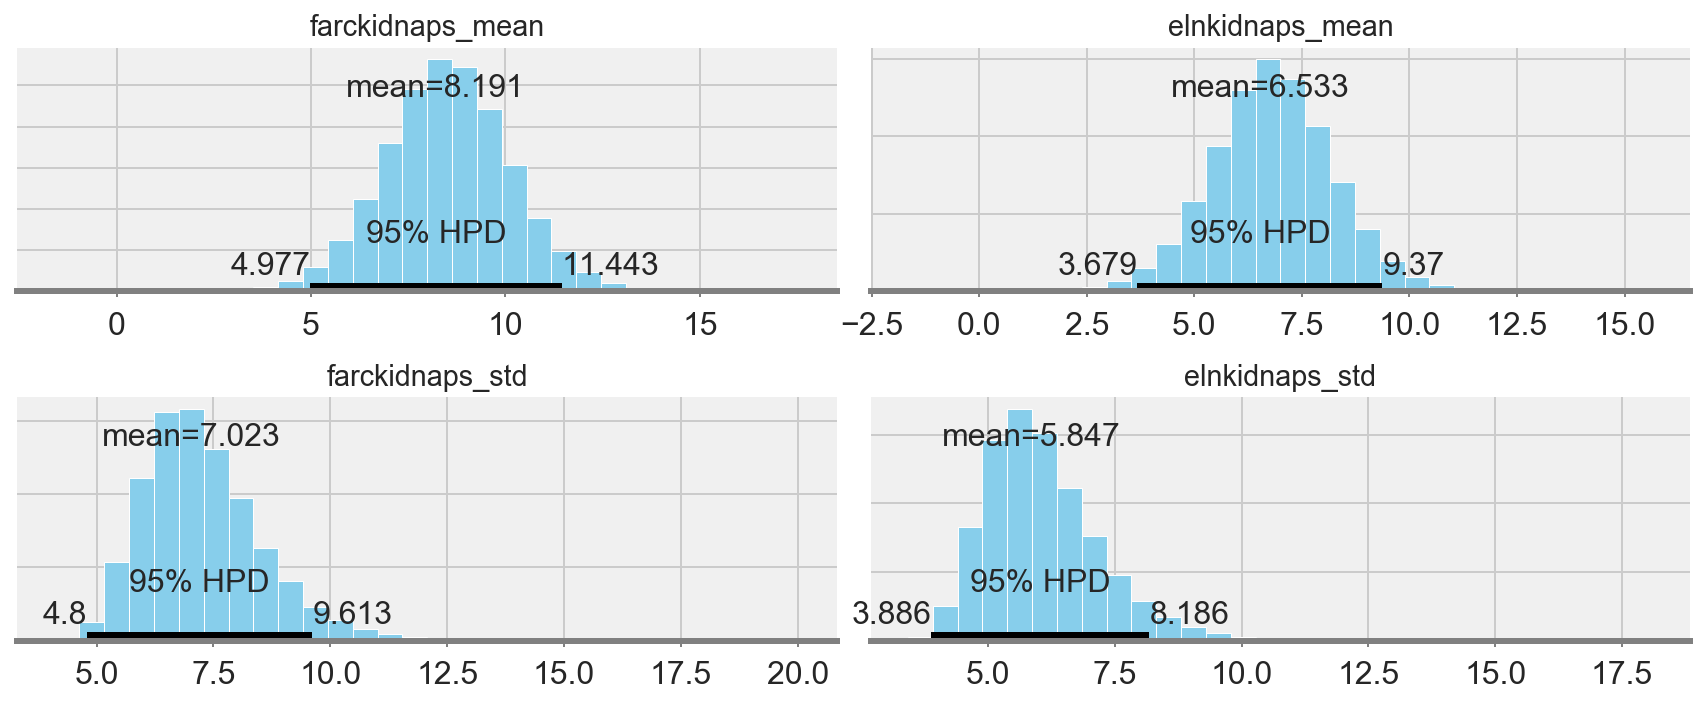

In [576]:
pm.plot_posterior(trace[3000:],
                  varnames=['farckidnaps_mean', 'elnkidnaps_mean', 'farckidnaps_std', 'elnkidnaps_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x178eb9750>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1797fa290>], dtype=object)

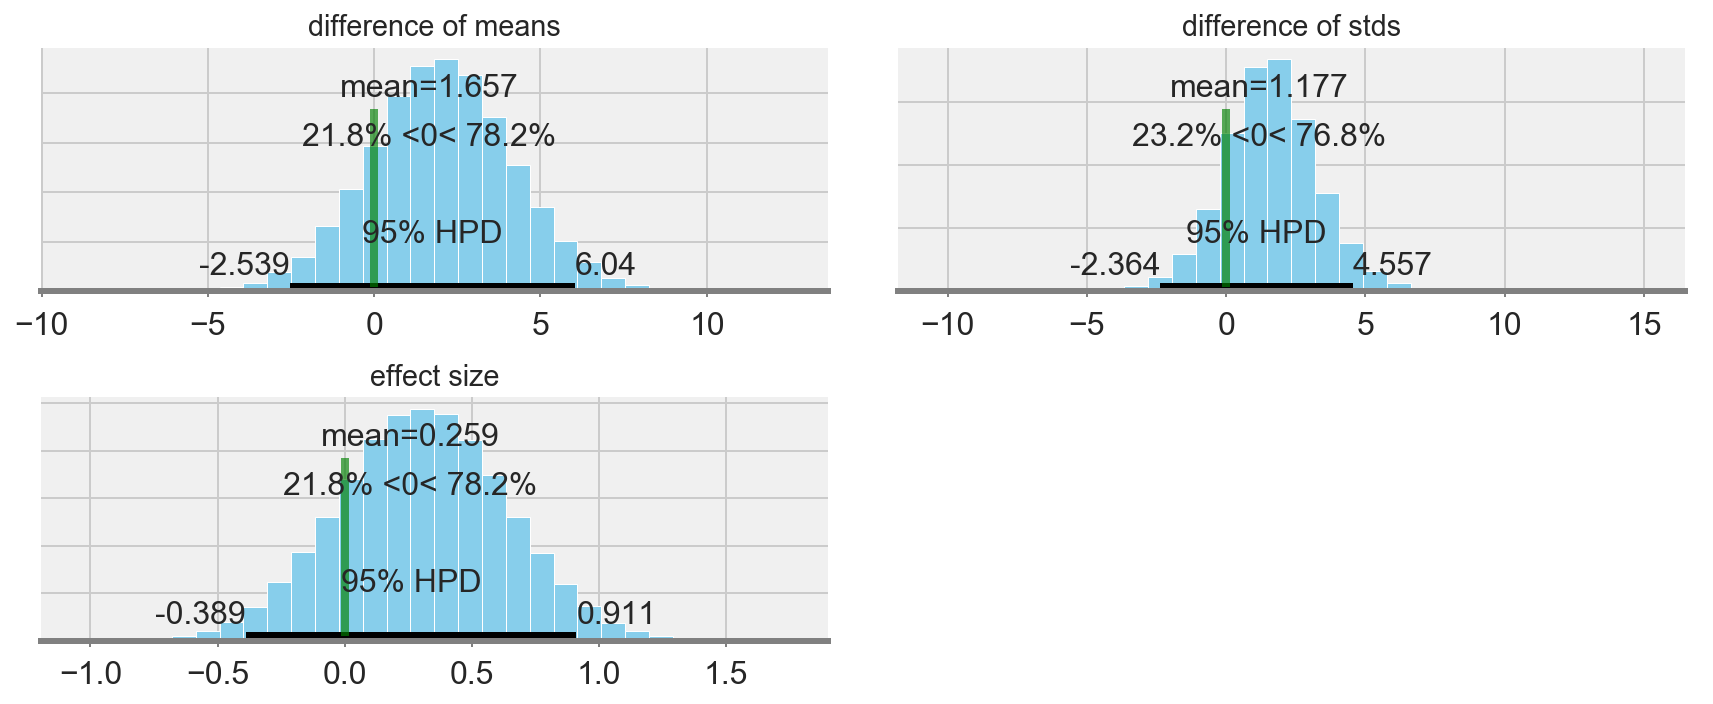

In [577]:
# From the graphs above and below I can tell there's no statistical difference between both groups in their use of kidnaps in Colombia.
pm.plot_posterior(trace[3000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

In [578]:
pm.summary(trace[3000:],
           varnames=['difference of means', 'difference of stds', 'effect size'])


difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.657            2.176            0.008            [-2.539, 6.040]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.643         0.225          1.655          3.090          5.956


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.177            1.734            0.007            [-2.364, 4.557]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.247         0.092          1.158          2.231          4.680


effect size:

  Mean             SD               MC Error         95% HPD i

## Part 3: Prediction 1993 Bombings

Values for 1993 are missing as part of a data transfer error. In this section, I will try to approximate a corresponding value to bombing world wide in 1993 by using rolling averages immediately prior and after 1993.

In [579]:
data.head()

,eventid,iyear,imonth,iday,country,country_txt,region,region_txt,city,latitude,longitude,success,attacktype1,attacktype1_txt,targtype1,targtype1_txt,gname,weaptype1,weaptype1_txt
datetime,,,,,,,,,,,,,,,,,,,
1970-07-02,197000000001,1970,7,2,58,Dominican Republic,2,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,1,1,Assassination,14,Private Citizens & Property,MANO-D,13,Unknown
1970-12-01,197000000002,1970,12,1,130,Mexico,1,North America,Mexico city,19.432608,-99.133207,1,6,Hostage Taking (Kidnapping),7,Government (Diplomatic),23rd of September Communist League,13,Unknown
1970-01-01,197001000001,1970,1,1,160,Philippines,5,Southeast Asia,Unknown,15.478598,120.599741,1,1,Assassination,10,Journalists & Media,Unknown,13,Unknown
1970-01-01,197001000002,1970,1,1,78,Greece,8,Western Europe,Athens,37.983773,23.728157,1,3,Bombing/Explosion,7,Government (Diplomatic),Unknown,6,Explosives/Bombs/Dynamite
1970-01-01,197001000003,1970,1,1,101,Japan,4,East Asia,Fukouka,33.580412,130.396361,1,7,Facility/Infrastructure Attack,7,Government (Diplomatic),Unknown,8,Incendiary


In [580]:
# Originally I fitted an ARIMA model, but the value was too high (approx: 2500), so I scratched the idea in fears I was implemending the model improperly.
# Later I toyed with the idea of using a linear regression by setting dummies, but ultimately decided that rolling average was simple and informed, giving me a value that was more in tune with time series trends.

rollavg = data[data['attacktype1']==3]


In [581]:
rollavg= rollavg.drop(['success', 'eventid', 'imonth', 'iday', 'country', 'country_txt', 'region', 'city', 'latitude', 'longitude', 'attacktype1', 'attacktype1_txt', 'targtype1', 'targtype1_txt', 'gname', 'weaptype1', 'weaptype1_txt'], axis=1)


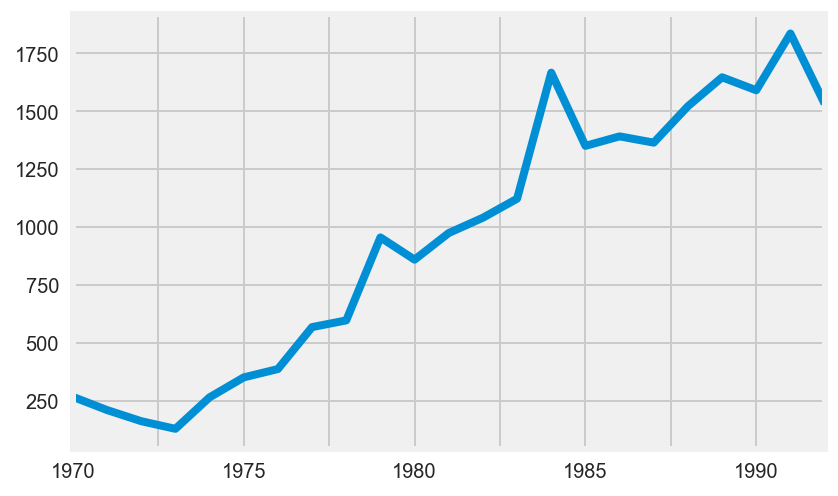

In [582]:
# Plotted the time based plots to spot yearly trends and take a look at proportions. When looking at this graphs, please be mindful of y-axis values.
pre93 = rollavg[rollavg.index < '1993']
post93 = rollavg[(rollavg.index < '2003') & (rollavg.index >= '1993')]

pre93.iyear.value_counts().sort_index().plot(kind='line')

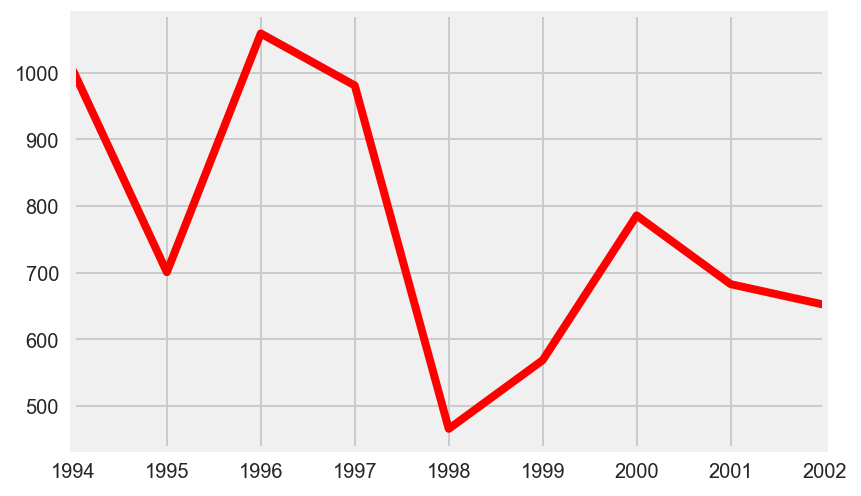

In [583]:
post93.iyear.value_counts().sort_index().plot(kind='line', color='r')

In [584]:
# xprep= pd.concat([pre93, post93])
# X = xprep.iyear.value_counts().sort_index()

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  after removing the cwd from sys.path.
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).std()
  """


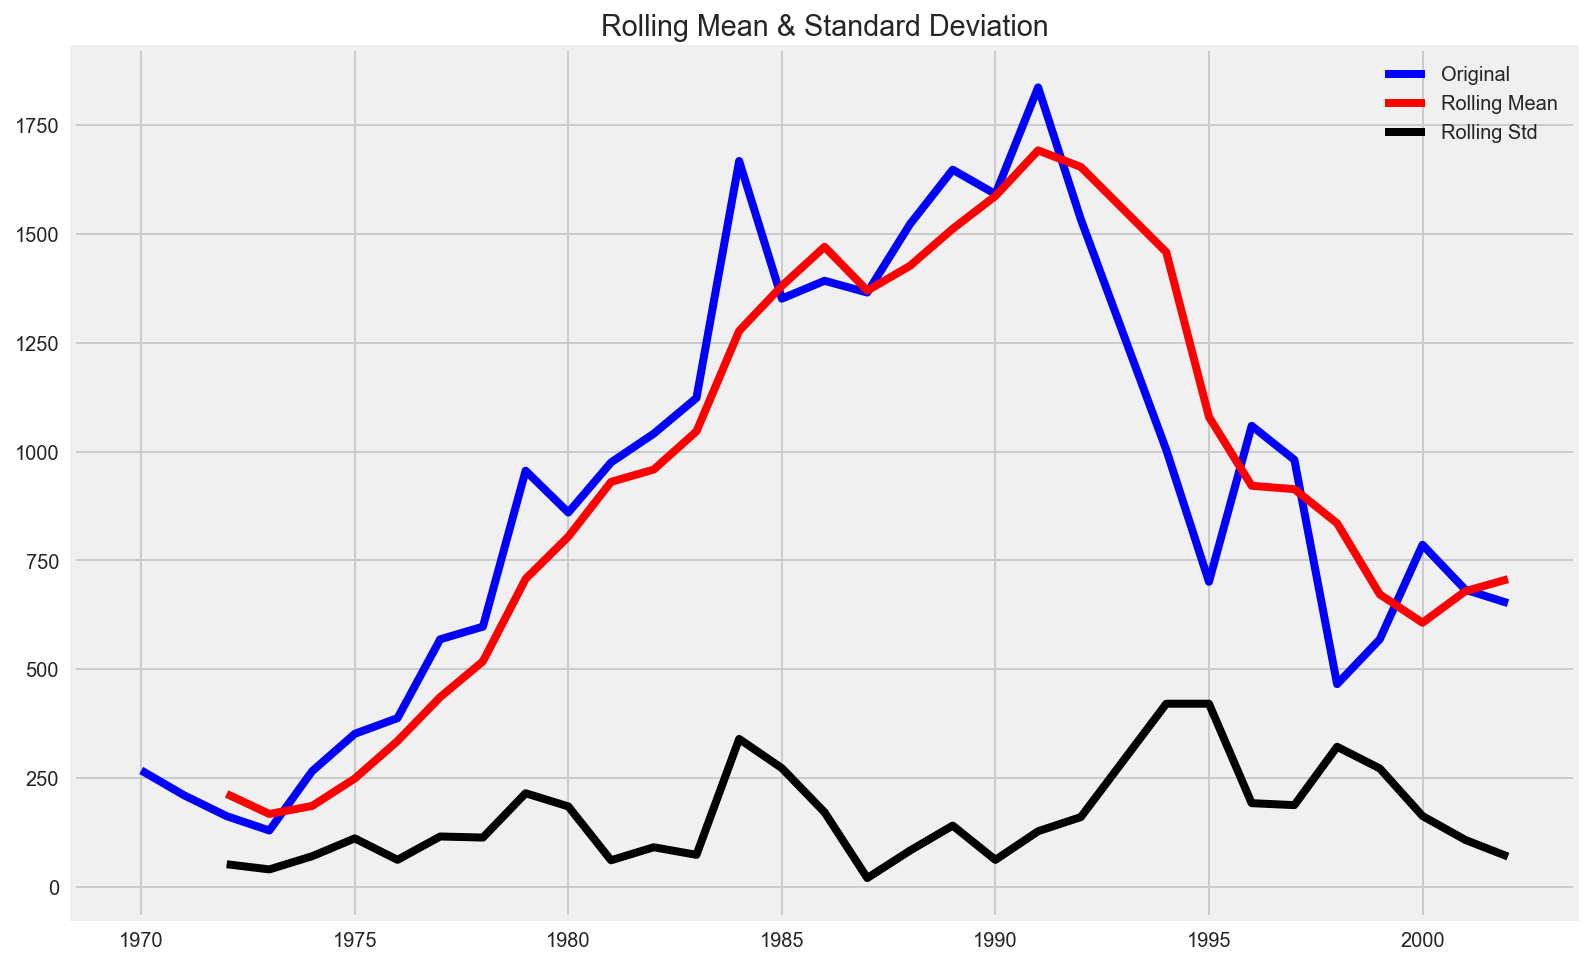

Results of Dickey-Fuller Test:
Test Statistic                 -2.671516
p-value                         0.079098
#Lags Used                      7.000000
Number of Observations Used    24.000000
Critical Value (5%)            -2.992216
Critical Value (1%)            -3.737709
Critical Value (10%)           -2.635747
dtype: float64


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()


1970            NaN
1971            NaN
1972     214.000000
1973     168.000000
1974     186.333333
1975     249.333333
1976     335.333333
1977     436.333333
1978     518.333333
1979     707.666667
1980     804.666667
1981     930.333333
1982     958.666667
1983    1046.333333
1984    1277.000000
1985    1380.333333
1986    1470.000000
1987    1369.333333
1988    1426.333333
1989    1511.333333
1990    1586.666667
1991    1691.333333
1992    1653.333333
1994    1457.666667
1995    1079.333333
1996     921.333333
1997     913.666667
1998     835.333333
1999     672.000000
2000     607.000000
2001     679.333333
2002     707.000000
Name: iyear, dtype: float64

In [585]:
# In the following cells I have included the result of several year-lags I tried in order to get close to some trend I could model my estimation on
# Found the smoothest rolling mean at a "window" of 7

def test_stationarity(timeseries, windownumber):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=windownumber)
    rolstd = pd.rolling_std(timeseries, window=windownumber)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
   # Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 
    return pd.rolling_mean(timeseries, window=windownumber)

# perform test
test_stationarity(X, 3)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  after removing the cwd from sys.path.
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
  """


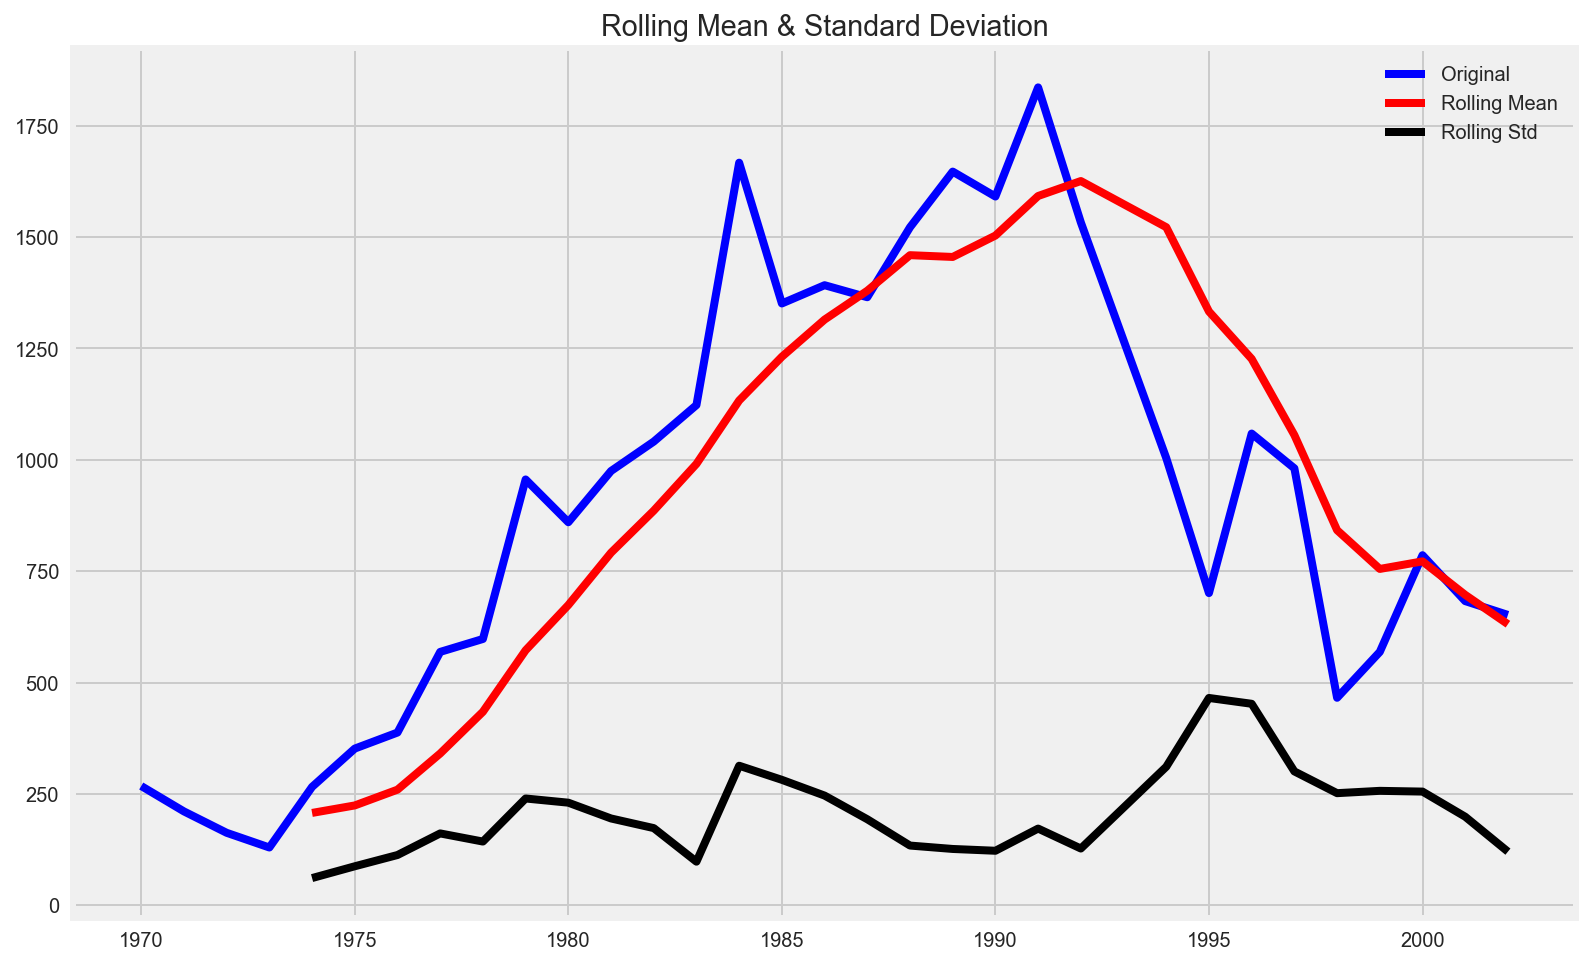

Results of Dickey-Fuller Test:
Test Statistic                 -2.671516
p-value                         0.079098
#Lags Used                      7.000000
Number of Observations Used    24.000000
Critical Value (5%)            -2.992216
Critical Value (1%)            -3.737709
Critical Value (10%)           -2.635747
dtype: float64


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()


1970       NaN
1971       NaN
1972       NaN
1973       NaN
1974     207.6
1975     224.4
1976     259.8
1977     341.0
1978     434.6
1979     572.6
1980     674.2
1981     791.6
1982     886.0
1983     991.0
1984    1133.2
1985    1231.4
1986    1314.8
1987    1379.6
1988    1459.4
1989    1455.4
1990    1503.4
1991    1592.2
1992    1625.8
1994    1522.2
1995    1333.0
1996    1226.6
1997    1055.6
1998     842.2
1999     755.2
2000     772.2
2001     697.0
2002     631.2
Name: iyear, dtype: float64

In [586]:
test_stationarity(X, 5)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  after removing the cwd from sys.path.
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  """


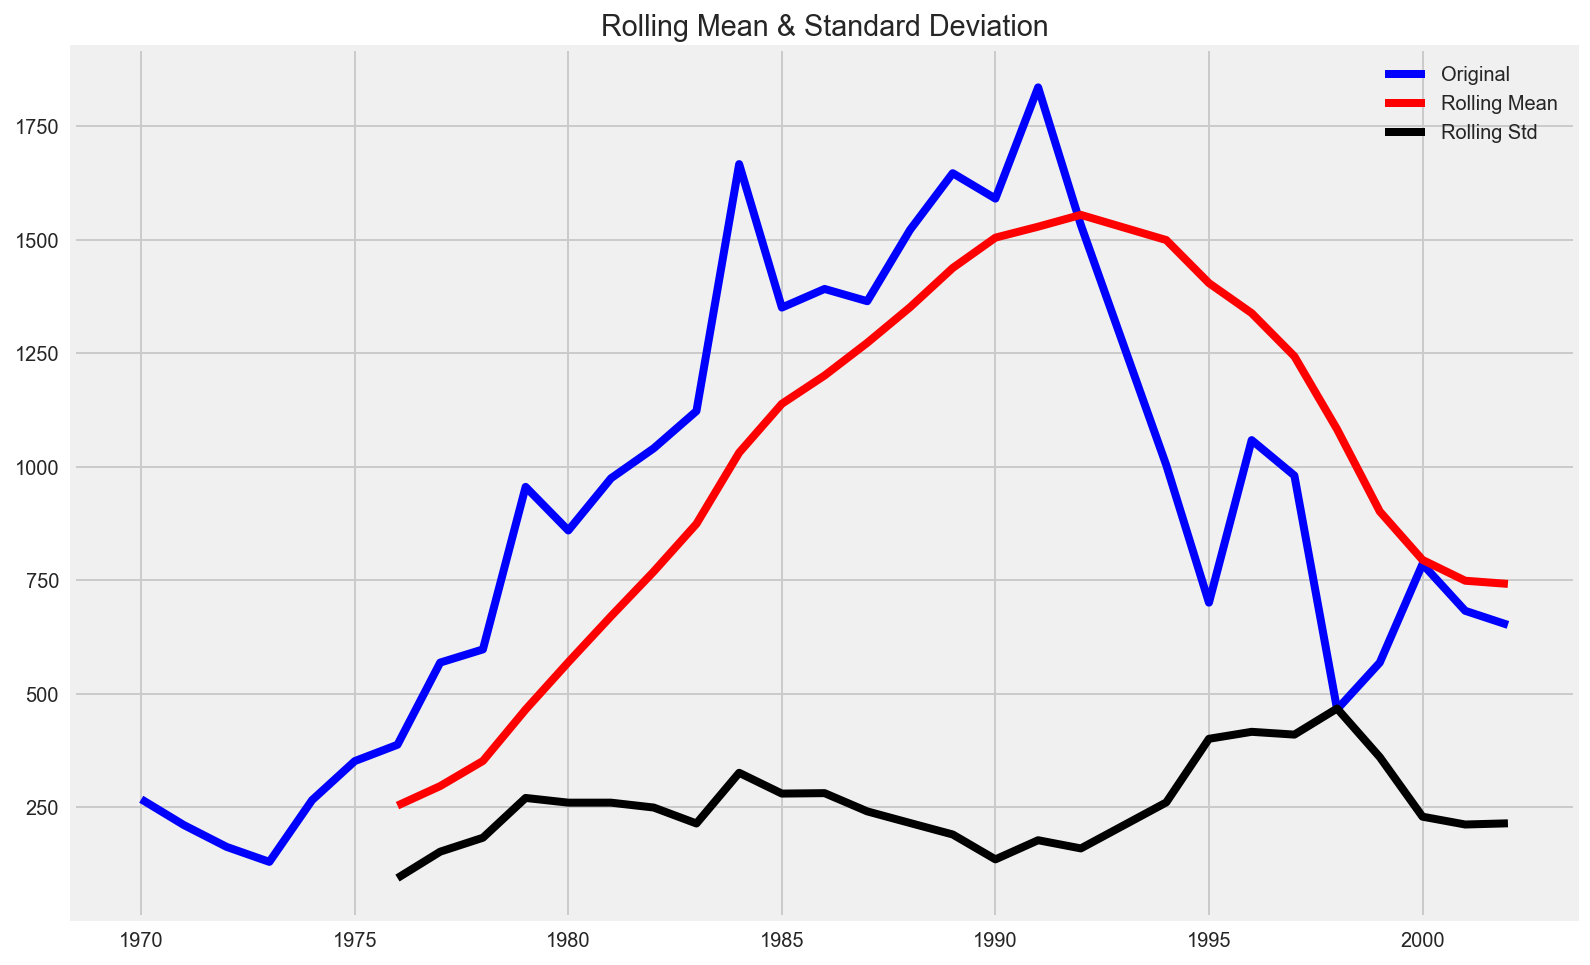

Results of Dickey-Fuller Test:
Test Statistic                 -2.671516
p-value                         0.079098
#Lags Used                      7.000000
Number of Observations Used    24.000000
Critical Value (5%)            -2.992216
Critical Value (1%)            -3.737709
Critical Value (10%)           -2.635747
dtype: float64


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()


1970            NaN
1971            NaN
1972            NaN
1973            NaN
1974            NaN
1975            NaN
1976     254.000000
1977     297.000000
1978     352.285714
1979     465.571429
1980     569.857143
1981     671.142857
1982     769.571429
1983     874.571429
1984    1031.428571
1985    1139.000000
1986    1201.285714
1987    1273.428571
1988    1351.571429
1989    1438.142857
1990    1505.000000
1991    1529.142857
1992    1555.142857
1994    1499.714286
1995    1404.857143
1996    1338.714286
1997    1243.571429
1998    1082.857143
1999     901.857143
2000     795.142857
2001     749.285714
2002     742.285714
Name: iyear, dtype: float64

In [587]:
test_stationarity(X, 7)

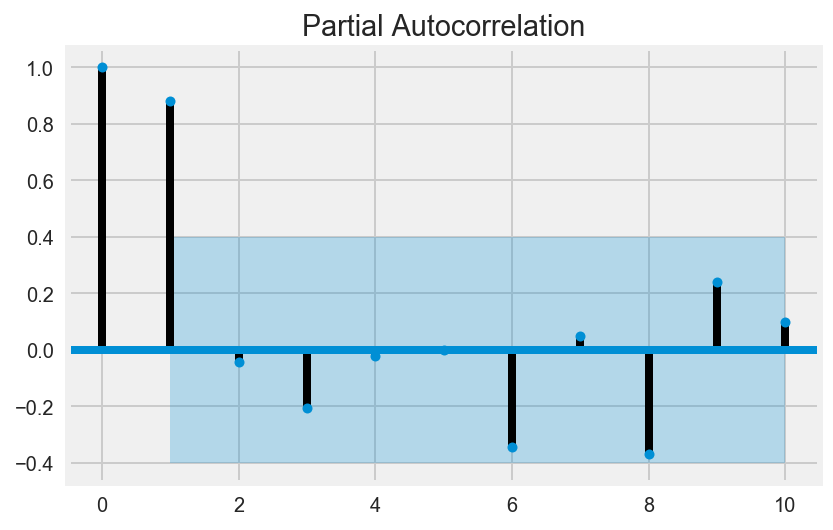

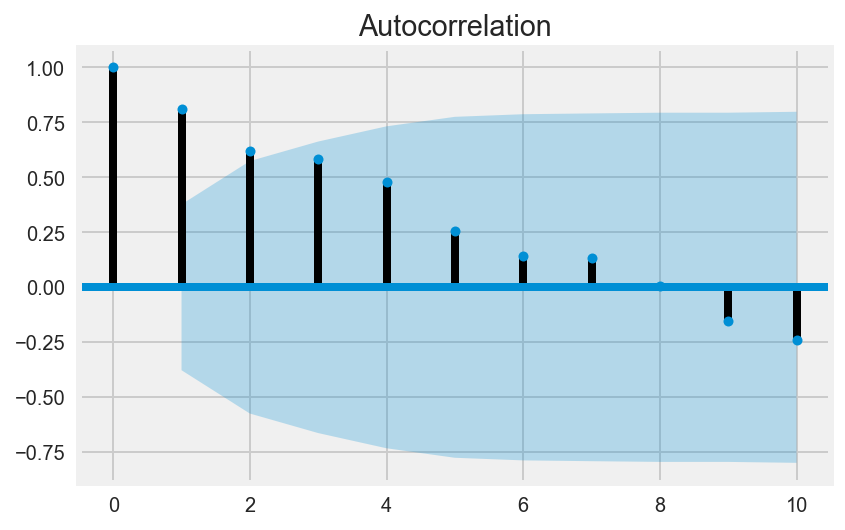

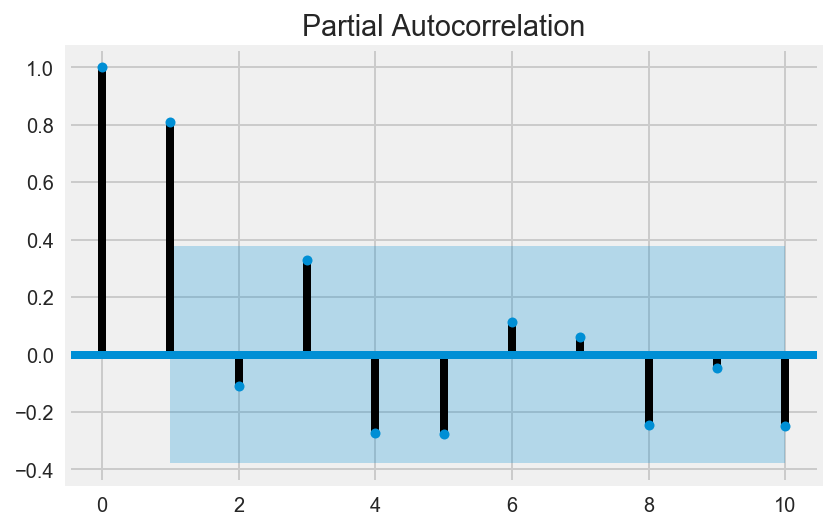

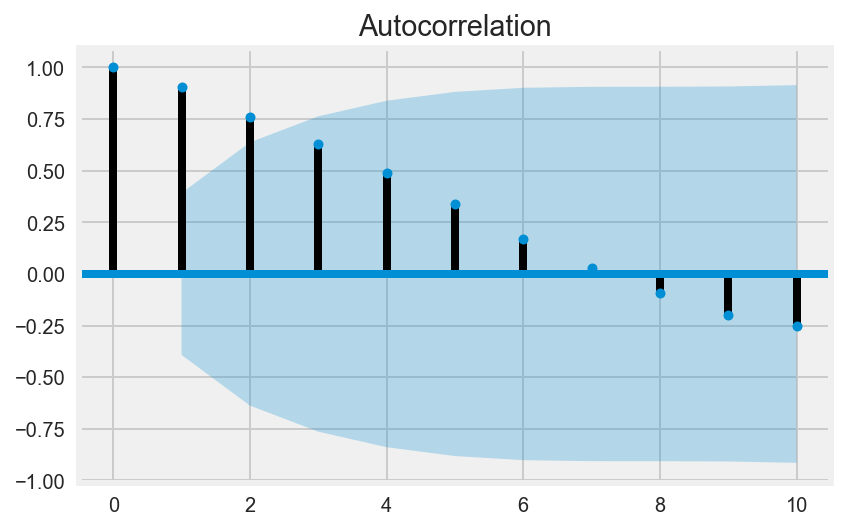

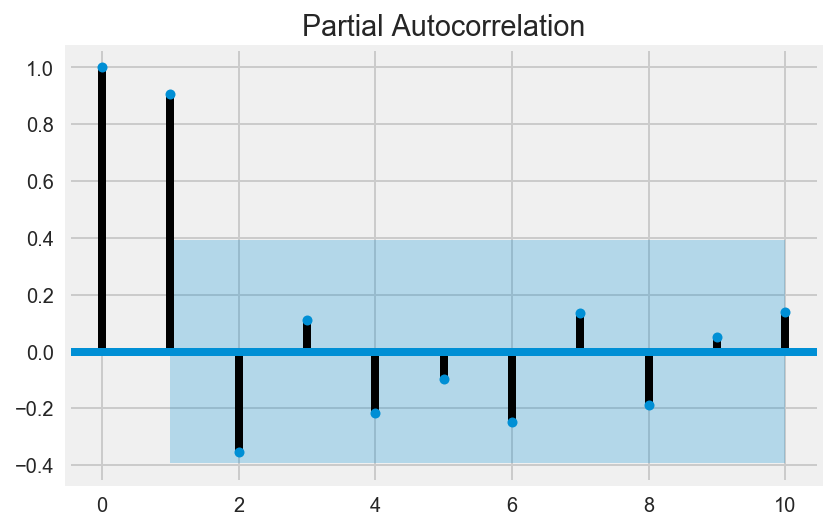

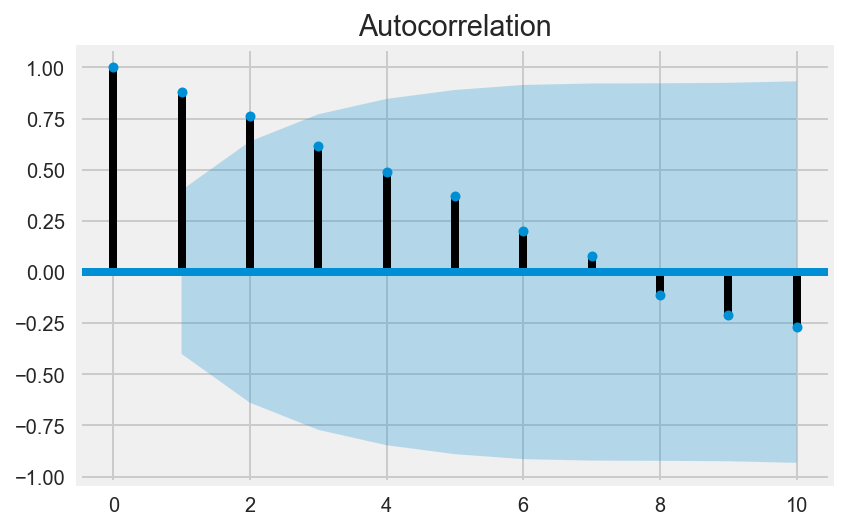

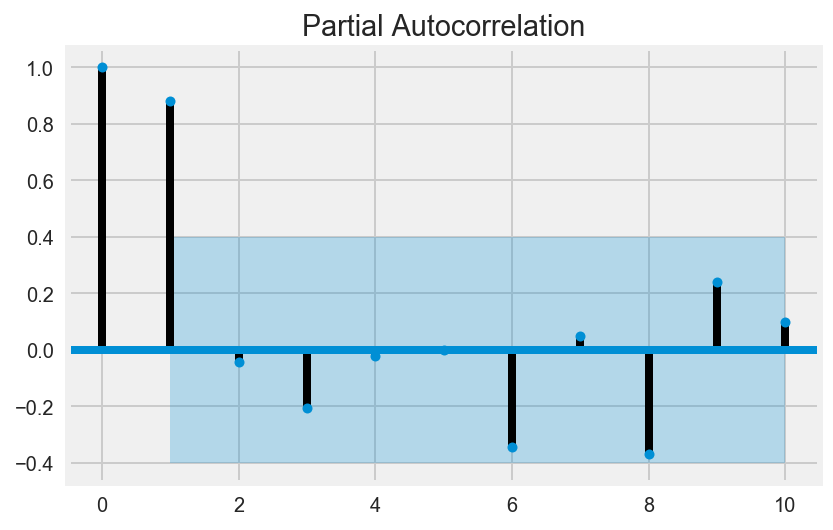

In [588]:
# I plotted acfs and pacfs in order to confirm my obersvation earlier.

plot_acf(X.diff(periods=5)[5:], lags=10)
plot_pacf(X.diff(periods=5)[5:], lags=10)
plot_acf(X.diff(periods=7)[7:], lags=10)
plot_pacf(X.diff(periods=7)[7:], lags=10)
plot_acf(X.diff(periods=8)[8:], lags=10)
plot_pacf(X.diff(periods=8)[8:], lags=10)
# diff0 = X.diff(periods=7)[7:]
# diff0.plot(title='Number of attacks')
# plot_acf(diff0, lags=10)
# plot_pacf(diff0, lags=10)

In [589]:
# I took the 3 previous and following entries to 1993 using the readouts of the stationarity test at lag 7. As you can see, this should account for the 7 year cycles hinted at by the data.

bombs93 = (1505+1529.14+1555.14+1499.71+1404.85+1338.71)/6
print "There were approximately "+str(bombs93)+" bombing in 1993 worldwide"

There were approximately 1472.09166667 bombing in 1993 worldwide


## Part 4: Methods

#### Bayesian Inference

    For my Bayesian analysis I was very interested to look at kidnappings in Colombia before and after 1998. Not only was that general time period considered a turn around point in the conflict with the guerrillas FARC and ELN, but it was also the time I immigrated to Colombia due to heightened security problems. It has always bothered me that I didn’t know a way to quantify risk in deciding if staying or leaving was the right decision.
    
    Originally, I had set the method to account for all kidnapping world-wide. After running the models and dealt with numbers a bit bigger than made sense, I decided to take advantage of one of the strengths of Bayesian statistics: It works well in small samples. I narrowed my sample to entries just in Colombia. Not only does that make the comparison a more germane one (Colombia has a disproportionate amounts of kidnappings in the dataset), but it may have served to spot a difference in terror tactics.
    
    Using a prior mean and standard deviation of all kidnappings in Colombia from 1970 to 1998, I instantiated a Bayesian estimation model. Looking at the posterior distributions I was surprised at the low number of projected kidnappings per year, considering how common in my childhood such stories recurred regarding these 2 groups in particular, but ultimately I’m more certain on the data that the bubble I lived in as a child.
    
    Ultimately, I was unable to establish that the two groups are statistically different when in comes to using kidnapping as a terror tactic. I reached this conclusion after subtracting posterior means and observing significant overlap with the difference of means posterior distribution.


#### Predicting Bombings in 1993

    My first instinct to solve this problem was to design a logistic regression and use prior data to predict 1993. However, after plotting the rolling average I noticed that 1993 happened to be in a relatively steep descent trend. For this reason, I decided to apply the simpler method of averaging rolling averages 3 years immediately before and after.
    
    To generate the best approximation, I plotted some time series plots with suspected window numbers that might help explain the variance. I found the best smoothness in rolling mean at around 7 periods. I later confirmed with autocorrelation plots that the best value lied somewhere between and close to 7 and 8. 
    
    Using the previous 3 and following 3 values for bombing in adjacent years, I used the above mentioned parameters and generated an average, which I consider to be a faithful approximation to the amount of successful bombings perpetrated worldwide in 1993: 1472
